In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import GPy
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, \
                                                      NegativeLowerConfidenceBound, \
                                                      MaxValueEntropySearch, \
                                                      ProbabilityOfImprovement
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def myplot(y_true_list, y_pred_list,var_list, title_str_list, color_list,region):
    fig, axes = plt.subplots(1, 2, figsize=(5.5*2, 4.5))
    fs = 18
    
    for i in range(len(axes)):
        axes[i].scatter(y_true_list[i], y_pred_list[i], alpha = 0.6, c = color_list[i])
        axes[i].plot(region,region, 'k--', alpha=0.75, zorder=0)
        axes[i].errorbar(y_true_list[i],y_pred_list[i], yerr = var_list[i], ms = 0, 
                 ls = '', capsize = 2, alpha = 0.6,
                 color = 'gray', zorder = 0)
        axes[i].set_xlabel('Ground Truth', fontsize = fs)
        axes[i].set_ylabel('Prediction', fontsize = fs)
        axes[i].set_xlim(region)
        axes[i].set_ylim(region)
        rmse = mse(y_true_list[i],y_pred_list[i],squared=False)
        title = title_str_list[i] + " (RMSE = %.3f)"%rmse
        axes[i].set_title(title, fontsize = fs)
        axes[i].grid(True, linestyle='-.')

In [3]:
# 参数空间
Tip_Height_min, Tip_Height_max, Tip_Height_step = [0.5, 50, 0.5]
Tip_Height_var = np.arange(Tip_Height_min, Tip_Height_max+0.1*Tip_Height_step,Tip_Height_step)
Tip_Height_num = len(Tip_Height_var)

Dispense_Speed_AS_min, Dispense_Speed_AS_max, Dispense_Speed_AS_step = [20,500,10]
Dispense_Speed_AS_var = np.arange(Dispense_Speed_AS_min, Dispense_Speed_AS_max+0.1*Dispense_Speed_AS_step,Dispense_Speed_AS_step)
Dispense_Speed_AS_num = len(Dispense_Speed_AS_var)

Spin_Speed_AS_min, Spin_Speed_AS_max, Spin_Speed_AS_step = [500,7000,100]
Spin_Speed_var = np.arange(Spin_Speed_AS_min,Spin_Speed_AS_max+0.1*Spin_Speed_AS_step,Spin_Speed_AS_step)
Spin_Speed_num = len(Spin_Speed_var)

Volume_AS_min, Volume_AS_max, Volume_AS_step = [50,300,10]
Volume_AS_var = np.arange(Volume_AS_min, Volume_AS_max+0.1*Volume_AS_step, Volume_AS_step)
Volume_AS_num = len(Volume_AS_var)

Timing_AS_min, Timing_AS_max, Timing_AS_step = [2,18,1]
Timing_AS_var = np.arange(Timing_AS_min, Timing_AS_max+0.1*Timing_AS_step,Timing_AS_step)
Timing_AS_num = len(Timing_AS_var)

x_label=[
    'Tip_Height',
    'Dispense_Speed_AS',
    'Spin_Speed_AS',
    'Volume_AS',
    'Timing_AS'
]

var_array = [
    Tip_Height_var,
    Dispense_Speed_AS_var,
    Spin_Speed_var,
    Volume_AS_var,
    Timing_AS_var
]


def x_normalizer(X, var_array = var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                         max(var_array[i]), 
                         min(var_array[i])) for i in range(len(x))])
            
    return np.array(x_norm)

def x_denormalizer(x_norm, var_array = var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                              max(var_array[i]), 
                              min(var_array[i])) for i in range(len(x))])

    return np.array(x_original)


def get_closest_array(suggested_x):
    
    def get_closest_value(given_value, array_list):
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        closest_value = min(array_list, key=absolute_difference_function)
        return closest_value
    
    var_list = var_array
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

In [4]:
data  = pd.read_excel('../高斯过程.xlsx',usecols=[i for i in range(1,9)],sheet_name='round6').dropna()
Data = data.values

X = Data[:,:5]
Y = Data[:,6]

X_norm = x_normalizer(X)
ss_y = 0.3
Y_norm = Y/ss_y 

Train_X, Test_X, Train_y, Test_y = train_test_split(X_norm, Y_norm, test_size = 0.3,random_state=1)


In [5]:
Y_norm

array([0.57921036, 1.03121747, 0.39792063, 0.75839459, 0.48327929,
       0.41032203, 0.33075321, 0.33081659, 0.11184334, 0.2000958 ,
       0.75826963, 0.21736726, 0.17069694, 0.32581634, 0.11564557,
       0.14920296, 0.43444485, 0.519572  , 0.23401393, 0.26159913,
       0.45373809, 0.53990352, 0.88464947, 0.39054193, 0.37283972,
       0.16304026, 0.6660023 , 1.22802472, 0.48923303, 0.2896915 ,
       0.50768582, 0.38422636, 0.0869071 , 0.20470687, 0.23269881,
       0.30328455, 0.12840877, 0.17210343, 0.12232588])

In [5]:
data.shape

(47, 8)

In [7]:
Train_y

array([0.2896915 , 0.30328455, 0.0869071 , 1.22802472, 0.48327929,
       0.11564557, 0.75826963, 0.23269881, 0.39054193, 0.37283972,
       0.20470687, 0.45373809, 0.23401393, 0.33075321, 0.32581634,
       0.33081659, 0.12232588, 1.03121747, 0.43444485, 0.57921036,
       0.14920296, 0.41032203, 0.21736726, 0.2000958 , 0.11184334,
       0.17069694, 0.17210343])

In [5]:
rbf = GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)
m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model_gpy = GPy.models.GPRegression(Train_X,Train_y.reshape(-1,1),kernel)

model_gpy.randomize()
model_gpy.optimize_restarts(num_restarts = 50)
model_gpy.optimize(messages=True)

y_pred_train = model_gpy.predict(Train_X)[0].ravel()
y_pred_test = model_gpy.predict(Test_X)[0].ravel()
var_train = np.sqrt(model_gpy.predict(Train_X)[1]).ravel()
var_test = np.sqrt(model_gpy.predict(Test_X)[1]).ravel()

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 1.7055427944212767
Optimization restart 2/50, f = 1.0882956357272988
Optimization restart 3/50, f = 1.527346972623235
Optimization restart 4/50, f = 4.446329682216945
Optimization restart 5/50, f = 1.52732925315685
Optimization restart 6/50, f = 1.088307969067234
Optimization restart 7/50, f = 1.0681814005750603
Optimization restart 8/50, f = 1.7055428025864465
Optimization restart 9/50, f = 1.705541129717453
Optimization restart 10/50, f = 1.705540937932792
Optimization restart 11/50, f = -0.1059296177251845
Optimization restart 12/50, f = 1.7055419994017562
Optimization restart 13/50, f = 1.088295637917458
Optimization restart 14/50, f = 1.705542790330636
Optimization restart 15/50, f = 1.7055425803743525
Optimization restart 16/50, f = 1.6029288105222683
Optimization restart 17/50, f = 1.0681814004515502
Optimization restart 18/50, f = 1.068181400729955
Optimization restart 19/50, f = 1.0882956384512283
Optimization restart 20/50, f = 1.088295638423645

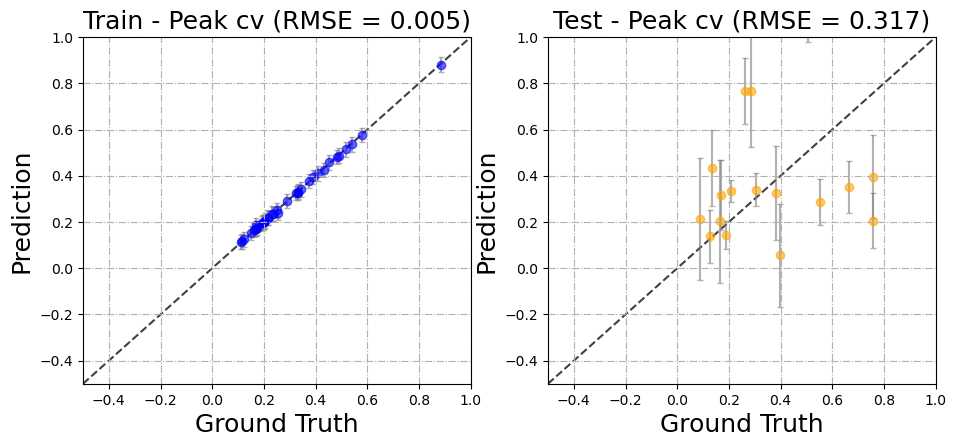

In [6]:
myplot([Train_y,Test_y],[y_pred_train,y_pred_test],[var_train,var_test],
       ["Train - Peak cv","Test - Peak cv"],
       ["blue","orange"],
      [-0.5,1])
#plt.savefig('result',dpi=1000)

In [7]:
X_normalize = x_normalizer(Data[:,:5])
Y_normalize = Data[:,6]/ss_y

rbf =  GPy.kern.RBF(input_dim=5, variance=1., lengthscale=1.,ARD=True)
linear = GPy.kern.Linear(input_dim=5,ARD =True)

m52 = GPy.kern.Matern52(input_dim = 5, ARD =True)
m52.lengthscale.constrain_bounded(1e-2, 1)
m52.variance.constrain_bounded(1e-1, 1000.0)

kernel = m52
model = GPy.models.GPRegression(X_normalize,Y_normalize.reshape(-1,1),kernel)

model.randomize()
model.optimize_restarts(num_restarts = 50)
model.optimize(messages=True)

reconstraining parameters Mat52.lengthscale
reconstraining parameters Mat52.variance


Optimization restart 1/50, f = 2.4945214955339132
Optimization restart 2/50, f = 2.0962513629740265
Optimization restart 3/50, f = 2.494521902952293
Optimization restart 4/50, f = 4.4982329878488585
Optimization restart 5/50, f = 2.494521394361783
Optimization restart 6/50, f = 2.0962513658306996
Optimization restart 7/50, f = 2.096251361694005
Optimization restart 8/50, f = 2.4945219897307247
Optimization restart 9/50, f = 2.4945217108403597
Optimization restart 10/50, f = 4.523034510138018
Optimization restart 11/50, f = 4.523034603748762
Optimization restart 12/50, f = 4.523033341441877
Optimization restart 13/50, f = 2.494521438179355
Optimization restart 14/50, f = 2.09625136475675
Optimization restart 15/50, f = 2.494530050268711
Optimization restart 16/50, f = 2.49452138606593
Optimization restart 17/50, f = 2.0962515407752775
Optimization restart 18/50, f = 4.498233075602123
Optimization restart 19/50, f = 2.494580060458798
Optimization restart 20/50, f = 2.0962513572915498
Opt

0.025136963120567873


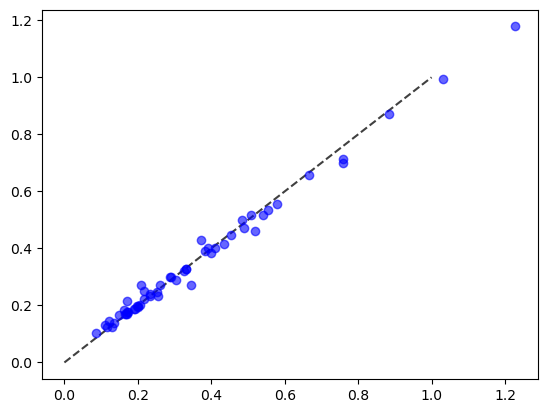

In [8]:
y_pred = model.predict(X_normalize)[0]
plt.scatter(Y_normalize,y_pred,c='b',alpha=0.6)
plt.plot([0,1],[0,1], 'k--', alpha=0.75, zorder=0)
print(mse(Y_normalize,y_pred,squared=False))

In [9]:
parameter_space = ParameterSpace([ContinuousParameter('Tip_Height', 0-1/(Tip_Height_num-1)/2, 1+1/(Tip_Height_num-1)/2),
                                  ContinuousParameter('Dispense_Speed_AS', 0-1/(Dispense_Speed_AS_num-1)/2, 1+1/(Dispense_Speed_AS_num-1)/2),
                                  ContinuousParameter('Spin_Speed', 0-1/(Spin_Speed_num-1)/2, 1+1/(Spin_Speed_num-1)/2),
                                  ContinuousParameter('Volume_AS', 0-1/(Volume_AS_num-1)/2, 1+1/(Volume_AS_num-1)/2),
                                  ContinuousParameter('Timing_AS', 0-1/(Timing_AS_num-1)/2, 1+1/(Timing_AS_num-1)/2)
                                  
                                  ])
parameter_space.parameters

[ContinuousParameter(Tip_Height, -0.005050505050505051, 1.005050505050505),
 ContinuousParameter(Dispense_Speed_AS, -0.010416666666666666, 1.0104166666666667),
 ContinuousParameter(Spin_Speed, -0.007692307692307693, 1.0076923076923077),
 ContinuousParameter(Volume_AS, -0.02, 1.02),
 ContinuousParameter(Timing_AS, -0.03125, 1.03125)]

In [25]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 10


acquisition = NegativeLowerConfidenceBound(objective_model, beta = 1)#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                   space=parameter_space, 
                                   acquisition=acquisition,
                                   batch_size = bs)


X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)
x = get_closest_array(x_denormalizer(X_new,var_array))
df_Xnew = pd.DataFrame(x, columns = x_label)
u = ss_y*model.predict(x_normalizer(x))[0]
sigma = ss_y*model.predict(x_normalizer(x))[1]
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([df_Xnew, pred], axis=1)
final


1000000
LPP


 D:\Anaconda\lib\site-packages\emukit-0.4.10-py3.9.egg\emukit\bayesian_optimization\acquisitions\log_acquisition.py:25: RuntimeWarning:invalid value encountered in log


Init point :  [0.46538428 0.14174281 0.2063762  0.79678339 0.13500668]
opt point :  (array([[0.46538428, 0.14174281, 0.2063762 , 0.79678339, 0.13500668]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.40654548 0.65710037 0.76375203 0.34645683 0.48595222]
opt point :  (array([[0.40654548, 0.65710037, 0.76375203, 0.34645683, 0.48595222]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.12557292 0.40123953 0.79458869 0.73835624 0.89446184]
opt point :  (array([[0.12557292, 0.40123953, 0.79458869, 0.73835624, 0.89446184]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.3114754  0.49468542 0.21246399 0.91643559 0.1817743 ]
opt point :  (array([[0.3114754 , 0.49468542, 0.21246399, 0.91643559, 0.1817743 ]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.11277673 0.11031596 0.28555327 0.43468651 0.35519231]
opt point :  (array([[0.11277673, 0.11031596, 0.28555327, 0.43468651, 0.35519231]]), array([[nan]]))
acq_max =  [[nan]]
Init point :  [0.13359687 0.00280644 0.783110

,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,23.5,90.0,1800.0,250.0,4.0,0.117163,2.999985e-09
1,20.5,340.0,5500.0,140.0,10.0,0.111852,2.999999e-09
2,6.5,210.0,5700.0,230.0,16.0,0.048912,3.000000e-09
3,16.0,260.0,1900.0,280.0,5.0,0.153911,6.206393e-02
4,6.0,70.0,2400.0,160.0,8.0,0.158329,4.710436e-02
5,7.0,20.0,5600.0,240.0,12.0,0.221726,3.780519e-02
6,14.5,100.0,1800.0,220.0,14.0,0.172430,3.164219e-02
7,25.0,340.0,4800.0,290.0,15.0,0.131051,4.599420e-02
8,48.0,240.0,600.0,220.0,17.0,0.135704,4.465114e-02
9,18.5,250.0,3800.0,160.0,18.0,0.163718,3.786902e-02


In [11]:
final.to_excel('Intensity cv2_gp.xlsx')

In [10]:
np.random.seed(1000)

objective_model = GPyModelWrapper(model)
bs = 1

beta = [0.1,1,10]
recommend_point = []
num = 3
for i in range(num):

    acquisition = NegativeLowerConfidenceBound(objective_model, beta = beta[i])#NegativeLowerConfidenceBound(objective_model, beta = beta[i])#ExpectedImprovement(objective_model, jitter=.1)#NegativeLowerConfidenceBound(objective_model, beta = 1)

    bayesopt= BayesianOptimizationLoop(model=objective_model, 
                                       space=parameter_space, 
                                       acquisition=acquisition,
                                       batch_size = bs)


    X_new = bayesopt.candidate_point_calculator.compute_next_points(bayesopt.loop_state)

    recommend_point.append(get_closest_array(x_denormalizer(X_new,var_array)))
    
recommend_point_pd = pd.DataFrame(np.array(recommend_point).reshape(-1,5), columns = x_label)

rp = x_normalizer(np.array(recommend_point).reshape(num,5))
u = ss_y*model.predict(rp)[0] #均值
sigma = ss_y*model.predict(rp)[1] #方差
pred = pd.DataFrame(np.append(u,sigma,axis=1),columns=['pred_mean','pred_sigma'])
final = pd.concat([recommend_point_pd, pred], axis=1)
final

1000000
Init point :  [ 9.82405684e-01 -9.01288749e-04 -5.78394161e-03  9.69822682e-01
 -1.22369147e-02]
opt point :  (array([[ 1.00505051, -0.01041667, -0.00769231,  1.02      , -0.03125   ]]), array([[0.01895432]]))
acq_max =  [[-0.01895432]]
1000000
Init point :  [1.00412109 0.30655386 0.75771747 0.99027316 0.99988828]
opt point :  (array([[1.00505051, 0.30145502, 0.77174543, 1.02      , 1.03125   ]]), array([[-0.21493637]]))
acq_max =  [[0.21493637]]
1000000
Init point :  [ 0.01024826  1.00656304  0.40503584  0.98590528 -0.01602759]
opt point :  (array([[-0.00505051,  1.01041667,  0.68579061,  1.02      , -0.03125   ]]), array([[-3.08356706]]))
acq_max =  [[3.08356706]]


,Tip_Height,Dispense_Speed_AS,Spin_Speed_AS,Volume_AS,Timing_AS,pred_mean,pred_sigma
0,50.0,20.0,500.0,300.0,2.0,0.016570,0.007291
1,50.0,160.0,5500.0,300.0,18.0,0.020045,0.022924
2,0.5,500.0,5000.0,300.0,2.0,0.052797,0.031114
